# QSVM for Breast Cancer Detection that will not only be created for utility, but for comparison to a SVM of each ones efficiency.

## Niko Tsiolas, July 2024

In [60]:

# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, normalized_mutual_info_score
from sklearn.feature_selection import SelectKBest, f_classif
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Load the data 
data = pd.read_csv('Breast_Cancer_Data.csv')

# Separating the features and target 
X = data.drop('diagnosis', axis=1)
y = data['diagnosis']

In [61]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature selection
selector = SelectKBest(f_classif, k=2)  # Select top 2 features to match the tutorial
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

# Apply SMOTE for balancing the dataset
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_selected, y_train)

# Set up the quantum feature map
feature_dim = X_train_balanced.shape[1]
print("Number of features:", feature_dim)

# Create the ZZFeatureMap
feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement="linear")

print("Feature map parameters:", feature_map.num_parameters)

Number of features: 2
Feature map parameters: 2


Training QSVC...
Making predictions...
QSVC Results:
Accuracy: 0.5701754385964912

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.47      0.45        43
           1       0.66      0.63      0.65        71

    accuracy                           0.57       114
   macro avg       0.55      0.55      0.55       114
weighted avg       0.58      0.57      0.57       114

Normalized Mutual Information Score: 0.00711228236376777


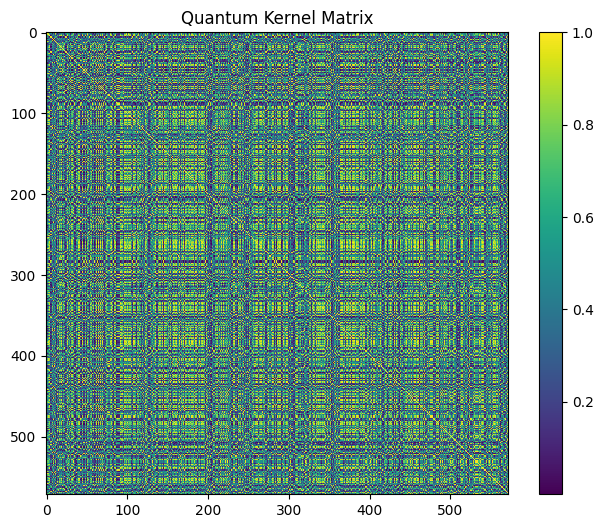

X_train_balanced shape: (572, 2)
y_train_balanced shape: (572,)
X_test_selected shape: (114, 2)
y_test shape: (114,)
Script execution completed.


In [62]:
# Set up the quantum kernel
sampler = Sampler()
fidelity = ComputeUncompute(sampler=sampler)
quantum_kernel = FidelityQuantumKernel(feature_map=feature_map, fidelity=fidelity)

# Create and train the QSVC
qsvc = QSVC(quantum_kernel=quantum_kernel, C=1.0)

print("Training QSVC...")
qsvc.fit(X_train_balanced, y_train_balanced)

print("Making predictions...")
y_pred_qsvc = qsvc.predict(X_test_selected)

print("QSVC Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_qsvc))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_qsvc))

# Calculate normalized mutual information score
nmi_score = normalized_mutual_info_score(y_test, y_pred_qsvc)
print(f"Normalized Mutual Information Score: {nmi_score}")

# Visualize kernel matrix
kernel_matrix = quantum_kernel.evaluate(X_train_balanced)
plt.figure(figsize=(8, 6))
plt.imshow(kernel_matrix, cmap='viridis', interpolation='nearest')
plt.title("Quantum Kernel Matrix")
plt.colorbar()
plt.show()

# Print data shapes for debugging
print("X_train_balanced shape:", X_train_balanced.shape)
print("y_train_balanced shape:", y_train_balanced.shape)
print("X_test_selected shape:", X_test_selected.shape)
print("y_test shape:", y_test.shape)

print("Script execution completed.")